In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
reload(database)
db = database.thomas_18_db

In [3]:
figdir_root='/mnt/home/szheng/ceph/place_variability/fig/explore_imaging/'
figdir = os.path.join(figdir_root,'pv_corr')
figdir= misc.get_or_create_subdir(figdir)

In [4]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

In [5]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)
import get_thomas_cell_metrics as gtcm
reload(gtcm)
import unimodal_nmf as unmf

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
%%time
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=True)
fr_map_trial_df_all = fr_map_all['fr_map_trial_df_all']

# occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']
occu_map = fr_map_all['occu_map_all']

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_all_mask_True.p exists; loading---
CPU times: user 214 ms, sys: 1.9 s, total: 2.12 s
Wall time: 22 s


In [7]:
# reshape fr_map_trial_df_all to make it easier to work with
fr_map_trial_df_all_day =fr_map_trial_df_all.unstack(level=2).swaplevel(0,1,axis=1).sort_index(axis=1) # day in column
fr_map_trial_df_all_per_uid=fr_map_trial_df_all.unstack(level=(2,3)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')
frmap_all_day = frmap.unstack(level=2).swaplevel(0,1,axis=1).sort_index(level=0,axis=1)

In [8]:
reload(gtcm)
reload(pa)
per_cell_metrics=gtcm.get_variability_metrics(frmap,occu_map,fr_map_trial_df_all)

/mnt/home/szheng/projects/util_code/place_cell_analysis.py:213: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=frmap.loc[kk].dropna(axis=1)
/mnt/home/szheng/projects/util_code/place_cell_analysis.py:205: RuntimeWarning: invalid value encountered in true_divide
  div = (fr_map_v / fr_mean[:,None])


In [9]:
region,exp = db.iloc[0][['region','exp_ind']]
isnovel =0

In [32]:
reload(gtcm)
fr_map_trial_df_all_day_sub = fr_map_trial_df_all_day.loc[(region,exp,isnovel),:].dropna(axis=1,how='all')
beg_end_corr_diff_df = gtcm.get_end_beg_diff_minus_beg_end_same_all(fr_map_trial_df_all_day_sub,cell_level=0,n_tr = 3)



100%|██████████| 574/574 [00:06<00:00, 84.33it/s]


In [67]:
beg_end_corr_diff_df

end_beg_across  beg_end_same      diff  across_bigger
0   0        0.222299     -0.063602  0.285901           True
    1       -0.385236      0.072249 -0.457484          False
    2        0.346437      0.545101 -0.198665          False
1   0       -0.150190      0.063347 -0.213537          False
    1       -0.074937      0.125483 -0.200420          False
...               ...           ...       ...            ...
572 1       -0.083965      0.159611 -0.243575          False
    2        0.146789      0.409610 -0.262821          False
573 0        0.139550     -0.106802  0.246352           True
    1       -0.089680     -0.006637 -0.083044          False
    2       -0.164041      0.114094 -0.278135          False

[1722 rows x 4 columns]

In [113]:
sim = fr_map_trial_df_all_day_sub.corr()

In [134]:
reload(gtcm)
n_roll_min = 2
nrepeats = 200
n_tr = 3
day_level = 0
diff_l,end_beg_l,beg_end_mean_l = gtcm.get_end_beg_diff_minus_beg_end_same_direct(sim,n_tr=n_tr,day_level=day_level)
pval,diff_l_sh_l = gtcm.shuffle_test_end_beg_diff_minus_beg_end_same(sim,n_tr=n_tr,n_roll_min=n_roll_min,nrepeats = nrepeats)


In [10]:
# pv across_within_diff all sessions
import tqdm
gpb = fr_map_trial_df_all_day.groupby(level=(0,1,2))
n_tr = 3
diff_l_all = {}
end_beg_l_all = {}
beg_end_mean_l_all = {}
for (region,exp,isnovel),val in tqdm.tqdm(gpb):
    sim = val.dropna(axis=1,how='all').corr()
    diff_l,end_beg_l,beg_end_mean_l = gtcm.get_end_beg_diff_minus_beg_end_same_direct(sim,n_tr=n_tr,day_level=0)
    key=(region,exp,isnovel)
    diff_l_all[key] = pd.Series(diff_l)
    end_beg_l_all[key] = pd.Series(end_beg_l)
    beg_end_mean_l_all[key]=pd.Series(beg_end_mean_l)
diff_l_all = pd.concat(diff_l_all,axis=0)
end_beg_l_all = pd.concat(end_beg_l_all,axis=0)
beg_end_mean_l_all = pd.concat(beg_end_mean_l_all,axis=0)


100%|██████████| 62/62 [00:09<00:00,  6.57it/s]


In [15]:
diff_l_all_df = diff_l_all.reset_index().rename({'level_0':'region','level_1':'exp','level_2':'isnovel','level_3':'day',0:'diff'},axis=1)



In [35]:
region='CA1'
isnovel=0
xx=diff_l_all.loc[region,slice(None),isnovel]
scipy.stats.wilcoxon(xx)

WilcoxonResult(statistic=98.0, pvalue=0.0007033341098576784)

<Axes: >

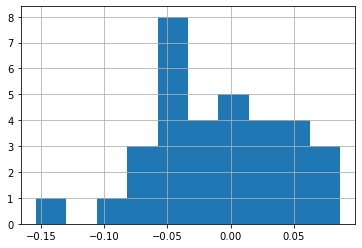

In [32]:
diff_l_all.loc['CA1',slice(None),isnovel]

<Axes: xlabel='region', ylabel='diff'>

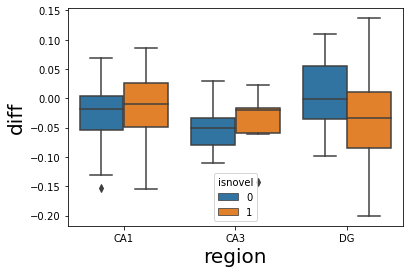

In [30]:
sns.boxplot(data=diff_l_all_df,x='region',y='diff',hue='isnovel')

In [193]:
end_beg_l_all

{('CA1', 0, 0): array([0.12282393, 0.10149085, 0.03565654]),
 ('CA1', 0, 1): array([0.14328554, 0.07352385, 0.00761709]),
 ('CA1', 1, 0): array([0.08115545]),
 ('CA1', 1, 1): array([0.15030451]),
 ('CA1', 3, 0): array([0.09640787]),
 ('CA1', 3, 1): array([0.10987778]),
 ('CA1', 4, 0): array([0.08884261]),
 ('CA1', 4, 1): array([0.15461483]),
 ('CA1', 5, 0): array([0.05659347]),
 ('CA1', 5, 1): array([0.18999372]),
 ('CA1', 6, 0): array([0.06116997]),
 ('CA1', 6, 1): array([0.05446103]),
 ('CA1', 7, 0): array([0.04656908, 0.04366731]),
 ('CA1', 7, 1): array([0.04773897, 0.03878782]),
 ('CA1', 8, 0): array([0.02425234, 0.02587083]),
 ('CA1', 8, 1): array([0.0494076 , 0.04482961]),
 ('CA1', 9, 0): array([0.32079409]),
 ('CA1', 9, 1): array([0.17992202]),
 ('CA1', 10, 0): array([0.11603121, 0.14378369, 0.14271982, 0.12558894]),
 ('CA1', 10, 1): array([0.16568847, 0.26931315, 0.2174291 , 0.28370896]),
 ('CA1', 11, 0): array([0.06950324, 0.06380029, 0.04668274, 0.06198571]),
 ('CA1', 11, 1):

In [133]:
sim_reind

0                                                              \
            6         7         8         9         10        11        12   
0 6   1.000000  0.390133  0.256704  0.336561  0.374095  0.296648  0.306788   
  7   0.390133  1.000000  0.286113  0.368674  0.433869  0.372795  0.406078   
  8   0.256704  0.286113  1.000000  0.215007  0.138078  0.190524  0.236995   
  9   0.336561  0.368674  0.215007  1.000000  0.259645  0.314850  0.258111   
  10  0.374095  0.433869  0.138078  0.259645  1.000000  0.381801  0.555147   
...        ...       ...       ...       ...       ...       ...       ...   
3 12  0.134886  0.225511  0.112724  0.260948  0.202814  0.169063  0.154293   
  13  0.123681  0.145851  0.069813  0.138853  0.130883  0.150585  0.095132   
  0   0.166774  0.195748  0.127494  0.184672  0.078524  0.251960  0.158784   
  1   0.198036  0.291413  0.142808  0.186008  0.206405  0.246604  0.235848   
  2   0.096920  0.188833  0.131844  0.125685  0.117006  0.162327  0.132672   

                                    ...         3                      \
            13        14        15  ...        7         8         9    
0 6   0.302216  0.274212  0.160350  ...  0.103930  0.100846  0.160278   
  7   0.364393  0.383692  0.329676  ...  0.153518  0.117859  0.169863   
  8   0.136157  0.156514  0.285092  ...  0.119099  0.094866  0.089051   
  9   0.270303  0.289699  0.208048  ...  0.160616  0.137032  0.202287   
  10  0.507353  0.434599  0.199928  ...  0.097466  0.101501  0.155770   
...        ...       ...       ...  ...       ...       ...       ...   
3 12  0.159622  0.206070  0.107180  ...  0.394956  0.445662  0.528748   
  13  0.110343  0.120756  0.074680  ...  0.238138  0.282060  0.496172   
  0   0.084845  0.215136  0.101834  ...  0.235322  0.217759  0.177950   
  1   0.184308  0.169728  0.114958  ...  0.293882  0.397970  0.254336   
  2   0.083498  0.145260  0.114173  ...  0.339561  0.323539  0.310083   

                                                                            
            10        11        12        13        0         1         2   
0 6   0.134264  0.092356  0.134886  0.123681  0.166774  0.198036  0.096920  
  7   0.158799  0.129980  0.225511  0.145851  0.195748  0.291413  0.188833  
  8   0.083230  0.077228  0.112724  0.069813  0.127494  0.142808  0.131844  
  9   0.202633  0.201220  0.260948  0.138853  0.184672  0.186008  0.125685  
  10  0.161866  0.084174  0.202814  0.130883  0.078524  0.206405  0.117006  
...        ...       ...       ...       ...       ...       ...       ...  
3 12  0.540784  0.537238  1.000000  0.448184  0.200355  0.257211  0.305816  
  13  0.396919  0.435570  0.448184  1.000000  0.117697  0.249038  0.208590  
  0   0.165373  0.159725  0.200355  0.117697  1.000000  0.539344  0.220106  
  1   0.267123  0.203558  0.257211  0.249038  0.539344  1.000000  0.296313  
  2   0.345604  0.311814  0.305816  0.208590  0.220106  0.296313  1.000000  

[87 rows x 87 columns]

(array([17., 42., 85., 50., 73., 40., 37., 23.,  7.,  4.]),
 array([0.04209288, 0.09461451, 0.14713613, 0.19965775, 0.25217937,
        0.304701  , 0.35722262, 0.40974424, 0.46226587, 0.51478749,
        0.56730911]),
 <BarContainer object of 10 artists>)

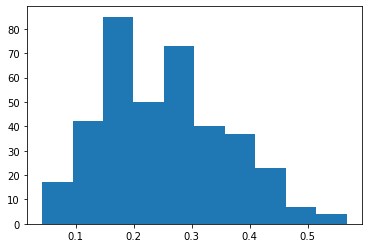

In [149]:
xx=sim.loc[(0,slice(None)),(0,slice(None))].values
xx_triu=xx[np.triu_indices_from(xx,1)]
plt.hist(xx_triu)

(array([ 8., 44., 64., 65., 76., 51., 35., 23.,  9.,  3.]),
 array([-0.02671893,  0.03325747,  0.09323387,  0.15321027,  0.21318667,
         0.27316308,  0.33313948,  0.39311588,  0.45309228,  0.51306868,
         0.57304509]),
 <BarContainer object of 10 artists>)

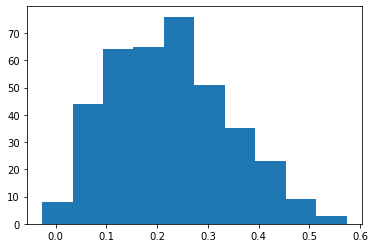

In [153]:
xx=sim.loc[(1,slice(None)),(1,slice(None))].values
xx_triu=xx[np.triu_indices_from(xx,1)]
plt.hist(xx_triu)

In [170]:
fr_map_trial_df_all_day_sub[0]

0         1         2         3         4         5         6   \
0   0   0.060726  0.188656  0.004878  0.261468  0.031526  0.129807  0.288961   
    1   0.069335  0.184911  0.013803  0.254768  0.025733  0.137196  0.327122   
    2   0.085799  0.171355  0.023715  0.240149  0.016996  0.143388  0.379246   
    3   0.110922  0.146501  0.032814  0.212043  0.009521  0.138512  0.408238   
    4   0.145311  0.117062  0.040620  0.162179  0.005366  0.119364  0.389332   
...          ...       ...       ...       ...       ...       ...       ...   
573 35  0.000000  0.008748  0.026642  0.022718  0.009228  0.024301  0.015523   
    36  0.000000  0.010563  0.028897  0.000000  0.013247  0.013109  0.019064   
    37  0.000000  0.012466  0.031365  0.000000  0.015466  0.004765  0.021084   
    38  0.000000  0.014131  0.033685  0.000000  0.016276  0.000341  0.021631   
    39  0.000000  0.015134  0.044027  0.000000  0.016421  0.000000  0.021519   

              7         8         9   ...        18        19        20  \
0   0   0.161038  0.116570  0.092725  ...  0.002121  0.020014  0.066141   
    1   0.181863  0.125764  0.094522  ...  0.003954  0.038427  0.067926   
    2   0.213644  0.135444  0.096098  ...  0.006307  0.073667  0.068997   
    3   0.241122  0.137440  0.094697  ...  0.008353  0.121149  0.066056   
    4   0.250962  0.129765  0.088831  ...  0.010785  0.171798  0.057900   
...          ...       ...       ...  ...       ...       ...       ...   
573 35  0.068643  0.000000  0.054132  ...  0.000000  0.057227  0.000000   
    36  0.073371  0.000000  0.050261  ...  0.000000  0.056309  0.000000   
    37  0.073618  0.000000  0.041556  ...  0.000000  0.054225  0.000000   
    38  0.071267  0.000000  0.031121  ...  0.000000  0.052363  0.000000   
    39  0.069084  0.000000  0.023879  ...  0.000000  0.051355  0.000000   

              21        22        23        24        25        26        27  
0   0   0.062798  0.079294  0.020313  0.000081  0.228987  0.008251  0.026740  
    1   0.068359  0.074308  0.020183  0.008809  0.249658  0.005235  0.028990  
    2   0.076835  0.065629  0.021101  0.023589  0.275462  0.000121  0.033636  
    3   0.083493  0.055024  0.024649  0.039336  0.283611  0.000000  0.040479  
    4   0.084424  0.044328  0.031338  0.050674  0.259187  0.000000  0.048630  
...          ...       ...       ...       ...       ...       ...       ...  
573 35  0.013566  0.049494  0.035424  0.000000  0.010554  0.000000  0.021086  
    36  0.001425  0.039524  0.025635  0.000000  0.000000  0.000000  0.015960  
    37  0.000000  0.025307  0.016072  0.005360  0.000000  0.000000  0.012479  
    38  0.000000  0.011142  0.008355  0.013749  0.000000  0.000000  0.010930  
    39  0.000000  0.002328  0.003975  0.018760  0.000000  0.000000  0.010547  

[22960 rows x 28 columns]

Text(0.5, 1.0, 'PV corr\nCA1, exp0, isnovel0')

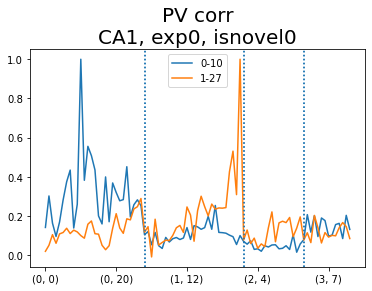

In [188]:
day_trial_l = [(0,10),(1,27)]
fig,ax=plt.subplots()
for day,trial in day_trial_l:
    ax=sim.loc[day,trial].plot(label=f'{day}-{trial}',ax=ax)
    ph.plot_day_on_heatmap(sim,vline=True,hline=False,ax=ax)
ax.legend()
ax.set_title(f'PV corr\n{region}, exp{exp}, isnovel{isnovel}')


(array([ 31., 103., 190., 183., 147.,  79.,  37.,   8.,   4.,   2.]),
 array([0.00047516, 0.03647124, 0.07246732, 0.1084634 , 0.14445949,
        0.18045557, 0.21645165, 0.25244773, 0.28844381, 0.32443989,
        0.36043597]),
 <BarContainer object of 10 artists>)

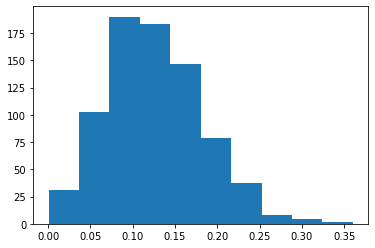

In [152]:
yy=sim.loc[(0,slice(None)),(1,slice(None))].values.flatten()
plt.hist(yy)

In [136]:
diff_l

array([ 0.00580764,  0.00402985, -0.12977007])

In [124]:
diff_l

array([-0.01523566, -0.03870189, -0.12543681])

In [137]:
end_beg_l

array([0.12282393, 0.10149085, 0.03565654])

In [138]:
beg_end_mean_l

array([0.11701629, 0.097461  , 0.1654266 ])

In [125]:
pval

array([0., 0., 0.])

In [139]:
diff_l_sh_l

array([[-0.16350051, -0.17986367, -0.2224544 ],
       [-0.09453854, -0.12767681, -0.22112393],
       [-0.17210462, -0.14723522, -0.2461993 ],
       [-0.20031881, -0.17540726, -0.23888486],
       [-0.17207924, -0.13761295, -0.19892147],
       [-0.17916538, -0.16462072, -0.25382071],
       [-0.1603094 , -0.12121675, -0.17807175],
       [-0.17237062, -0.19154143, -0.21370638],
       [-0.17504357, -0.15264231, -0.23934039],
       [-0.20882116, -0.20728063, -0.2206455 ],
       [-0.1916055 , -0.12027195, -0.21235591],
       [-0.17377062, -0.16665064, -0.21370638],
       [-0.17013346, -0.1590734 , -0.21733373],
       [-0.16177455, -0.08622568, -0.22589227],
       [-0.20470302, -0.15459572, -0.26296427],
       [-0.15668309, -0.13718736, -0.26513562],
       [-0.18375371, -0.19030195, -0.21235591],
       [-0.09575638, -0.10280846, -0.2206455 ],
       [-0.11345224, -0.13349228, -0.23378632],
       [-0.1559401 , -0.21061639, -0.23888486],
       [-0.18290562, -0.18402464, -0.256

In [117]:
pval

array([0.  , 0.  , 0.01])

In [46]:
reload(misc)

<module 'misc' from '/mnt/home/szheng/projects/util_code/misc.py'>

/mnt/home/szheng/projects/place_variability/code/thomas_18_data/get_thomas_cell_metrics.py:184: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


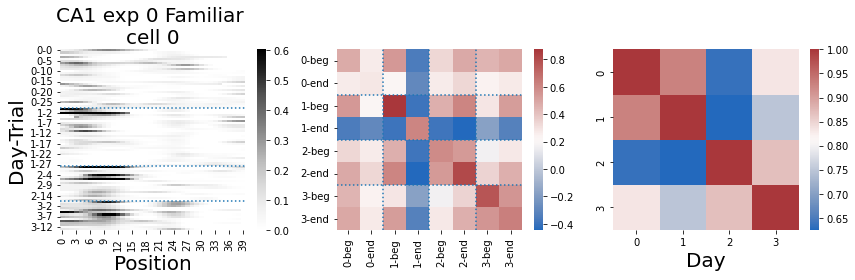

In [51]:
reload(gtcm)
region = 'CA1'
exp=0
isnovel=0
uid=0
dosave = True
gtcm.end_beg_diff_minus_beg_end_same_show_one_cell(fr_map_trial_df_all_day,frmap_all_day,vmax_quantile=0.99,region=region,exp=exp,isnovel=isnovel,uid=uid,
                                                dosave=dosave,savedir='',savefn_func = lambda x:f'across_within_diff_{x[0]}_exp{x[1]}_isnovel{x[2]}_cell{x[3]}',
                                                )


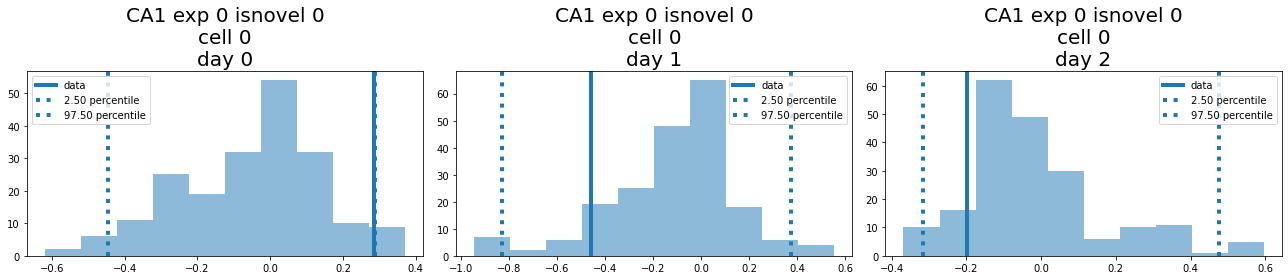

In [55]:
reload(gtcm)
dosave = True
gtcm.end_beg_diff_minus_beg_end_same_shuffle_show_one_cell(fr_map_trial_df_all_day,
                                n_tr=3,day_level=0,region=region,exp=exp,isnovel=isnovel,uid=uid,
                                dosave=dosave,savedir='',savefn_func = lambda x:f'across_within_diff_shuffle_{x[0]}_exp{x[1]}_isnovel{x[2]}_cell{x[3]}',
                                n_roll_min = 2,nrepeats = 200)

In [92]:
ddf_one = db.loc[(db['region']=='CA1')&(db['exp_ind']==0)]['data_dir_full'].iloc[0]

In [100]:
os.path.dirname(ddf_one)

'/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_0'

In [101]:
db.groupby(['region','exp_ind']).mean().index.shape

(31,)

In [105]:
import across_within_diff_per_cell_one_sess as awdpcos
reload(awdpcos)
awdpcos.main(0,test_mode=True)

  0%|          | 2/574 [00:10<51:11,  5.37s/it]


> /mnt/home/szheng/projects/place_variability/code/thomas_18_data/get_thomas_cell_metrics.py(161)shuffle_test_end_beg_diff_minus_beg_end_same_all()
    159     pval_d = pd.DataFrame(pval_d).T
    160     pdb.set_trace()
--> 161     diff_l_sh_l_all = pd.concat(diff_l_sh_l_all,axis=0) # (cell x nshuffle) x nacrossday
    162     return pval_d, diff_l_sh_l_all
    163 

ipdb> c


  0%|          | 2/574 [00:10<50:54,  5.34s/it]


> /mnt/home/szheng/projects/place_variability/code/thomas_18_data/get_thomas_cell_metrics.py(161)shuffle_test_end_beg_diff_minus_beg_end_same_all()
    159     pval_d = pd.DataFrame(pval_d).T
    160 
--> 161     diff_l_sh_l_all = pd.concat(diff_l_sh_l_all,axis=0) # (cell x nshuffle) x nacrossday
    162     return pval_d, diff_l_sh_l_all
    163 

ipdb> c
saved at /mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_0/across_within_diff_per_cell_mask_True.p


{'beg_end_corr_diff':          end_beg_across  beg_end_same      diff  across_bigger
 0 0   0        0.222299     -0.063602  0.285901           True
       1       -0.385236      0.072249 -0.457484          False
       2        0.346437      0.545101 -0.198665          False
   1   0       -0.150190      0.063347 -0.213537          False
       1       -0.074937      0.125483 -0.200420          False
 ...                 ...           ...       ...            ...
 1 572 1       -0.271404      0.209585 -0.480989          False
       2        0.096271      0.016993  0.079278           True
   573 0       -0.083012      0.268407 -0.351418          False
       1        0.624043      0.622410  0.001633           True
       2        0.252737      0.776830 -0.524093          False
 
 [3444 rows x 4 columns],
 'pval':         0      1     2
 0 0  0.05  0.835  0.92
   1  0.67  0.495  0.00
   2  0.05  0.350  0.01
 1 0  0.37  0.535  0.29
   1  0.01  0.960  0.45
   2  0.73  1.000  0.47,
 'diff

In [71]:
db.iloc[0]['data_dir_full']

'/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_0/day_0'

In [64]:
reload(gtcm)
pval_d, diff_l_sh_l_all = gtcm.shuffle_test_end_beg_diff_minus_beg_end_same_all(fr_map_trial_df_all_day_sub,cell_level=0,n_roll_min=2,nrepeats=200,n_max=3)



  0%|          | 2/574 [00:10<50:52,  5.34s/it]


> /mnt/home/szheng/projects/place_variability/code/thomas_18_data/get_thomas_cell_metrics.py(161)shuffle_test_end_beg_diff_minus_beg_end_same_all()
    159     pval_d = pd.DataFrame(pval_d).T
    160     pdb.set_trace()
--> 161     diff_l_sh_l_all = pd.concat(diff_l_sh_l_all,axis=0)
    162     return pval_d, diff_l_sh_l_all
    163 

ipdb> len(diff_l_sh_l_all)
3
ipdb> c


In [65]:
diff_l_sh_l_all

0         1         2
0 0    0.145824 -0.254495 -0.215707
  1   -0.065445 -0.144034 -0.158035
  2    0.127184 -0.043360 -0.011004
  3   -0.097207  0.242413 -0.119215
  4   -0.050619  0.191802  0.595319
...         ...       ...       ...
2 195  0.204193  0.352818 -0.214007
  196 -0.135419  0.061506 -0.186859
  197  0.406477 -0.082153 -0.051157
  198  0.013153  0.146028 -0.198888
  199  0.035024 -0.346453 -0.149060

[600 rows x 3 columns]

In [29]:
fr_map_trial_df_all_day_sub = fr_map_trial_df_all_day.loc[(region,exp,isnovel),:].dropna(axis=1,how='all')

n_tr = 3


gpb = fr_map_trial_df_all_day_sub.groupby(level=0)
pval_d = {}
for uid,val in tqdm.tqdm(gpb):
    sim = val.corr()
    pval = gtcm.shuffle_test_end_beg_diff_minus_beg_end_same(sim,n_roll_min=2,nrepeats = 200)
    pval_d[uid] = pval


  1%|          | 3/574 [00:11<36:25,  3.83s/it]

KeyboardInterrupt

